In [1]:
# 1) SETUP
import os, re, json, warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, f1_score

# ---- your file path (keep as is) ----
CSV_PATH = Path("/Users/muthuraj/Desktop/git hub/Mind-Metrics/Student Insomnia and Educational Outcomes Dataset_version-2.csv")

# ---- output dirs for slides ----
OUT_DIR = Path("./insomnia_out")
FIG_DIR = OUT_DIR / "figures"
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)


In [2]:
# 2) LOAD
df = pd.read_csv(CSV_PATH)
print("shape:", df.shape)
print(df.head(3))
print(df.columns.tolist())


shape: (996, 16)
             Timestamp 1. What is your year of study? 2. What is your gender?  \
0  10/24/2024 16:51:15               Graduate student                    Male   
1  10/24/2024 16:51:51                     Third year                    Male   
2  10/24/2024 16:52:21                     First year                  Female   

  3. How often do you have difficulty falling asleep at night?   \
0                           Often (5-6 times a week)              
1                           Often (5-6 times a week)              
2                       Sometimes (3-4 times a week)              

  4. On average, how many hours of sleep do you get on a typical day?  \
0                                          7-8 hours                    
1                                          7-8 hours                    
2                                          7-8 hours                    

  5. How often do you wake up during the night and have trouble falling back asleep?  \
0       

In [3]:
# 0) SETUP
import re, warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, f1_score

CSV_PATH = Path("/Users/muthuraj/Desktop/git hub/Mind-Metrics/Student Insomnia and Educational Outcomes Dataset_version-2.csv")

OUT = Path("./insomnia_out"); FIG = OUT/"figures"
OUT.mkdir(exist_ok=True); FIG.mkdir(parents=True, exist_ok=True)


In [4]:
# 1) LOAD & RENAME
raw = pd.read_csv(CSV_PATH)

rename_map = {
 'Timestamp': 'timestamp',
 '1. What is your year of study?': 'year',
 '2. What is your gender?': 'gender',
 '3. How often do you have difficulty falling asleep at night? ': 'sleep_difficulty',
 '4. On average, how many hours of sleep do you get on a typical day?': 'sleep_hours_band',
 '5. How often do you wake up during the night and have trouble falling back asleep?': 'night_awakenings',
 '6. How would you rate the overall quality of your sleep?': 'sleep_quality',
 '7. How often do you experience difficulty concentrating during lectures or studying due to lack of sleep?': 'concentration_difficulty',
 '8. How often do you feel fatigued during the day, affecting your ability to study or attend classes?': 'daytime_fatigue',
 '9. How often do you miss or skip classes due to sleep-related issues (e.g., insomnia, feeling tired)?': 'miss_classes',
 '10. How would you describe the impact of insufficient sleep on your ability to complete assignments and meet deadlines?': 'assignments_impact',
 '11. How often do you use electronic devices (e.g., phone, computer) before going to sleep?': 'devices_before_sleep',
 '12. How often do you consume caffeine (coffee, energy drinks) to stay awake or alert?': 'caffeine',
 '13. How often do you engage in physical activity or exercise?': 'physical_activity',
 '14. How would you describe your stress levels related to academic workload?': 'stress',
 '15. How would you rate your overall academic performance (GPA or grades) in the past semester?': 'academic_performance'
}
df = raw.rename(columns=rename_map).copy()

print(df.shape)
df.head(3)


(996, 16)


,timestamp,year,gender,sleep_difficulty,sleep_hours_band,night_awakenings,sleep_quality,concentration_difficulty,daytime_fatigue,miss_classes,assignments_impact,devices_before_sleep,caffeine,physical_activity,stress,academic_performance
0,10/24/2024 16:51:15,Graduate student,Male,Often (5-6 times a week),7-8 hours,Often (5-6 times a week),Good,Sometimes,Often,Often (3-4 times a week),Moderate impact,Often (5-6 times a week),Rarely (1-2 times a week),Sometimes (3-4 times a week),High stress,Average
1,10/24/2024 16:51:51,Third year,Male,Often (5-6 times a week),7-8 hours,Often (5-6 times a week),Good,Often,Sometimes,Sometimes (1-2 times a week),Major impact,Sometimes (3-4 times a week),Sometimes (3-4 times a week),Sometimes (3-4 times a week),Low stress,Good
2,10/24/2024 16:52:21,First year,Female,Sometimes (3-4 times a week),7-8 hours,Sometimes (3-4 times a week),Good,Often,Often,Sometimes (1-2 times a week),Major impact,Often (5-6 times a week),Often (5-6 times a week),Often (5-6 times a week),High stress,Below Average


In [5]:
# 2) CLEAN & ENCODE

# (A) Convert "7-8 hours"/"Less than 5 hours"/"More than 8 hours" → numeric midpoint
def parse_hours_band(s):
    if pd.isna(s): return np.nan
    s = str(s).lower()
    m = re.search(r'(\d+)\s*-\s*(\d+)', s)
    if m:
        a,b = map(float, m.groups()); return (a+b)/2.0
    if "less" in s and "5" in s: return 4.5
    if "more" in s and "8" in s: return 8.5
    m2 = re.search(r'(\d+(\.\d+)?)\s*hour', s)
    if m2: return float(m2.group(1))
    return np.nan

df["sleep_hours"] = df["sleep_hours_band"].apply(parse_hours_band).clip(lower=0, upper=16)

# (B) Standardize text to lowercase simplified labels
def norm(s):
    return str(s).strip().lower()

for c in [
    "sleep_difficulty","night_awakenings","sleep_quality",
    "concentration_difficulty","daytime_fatigue","miss_classes",
    "assignments_impact","devices_before_sleep","caffeine",
    "physical_activity","stress","academic_performance"
]:
    df[c] = df[c].map(norm)

# (C) Frequency → ordinal (1=never/least, 5=most)
freq_order = ["never","rarely","sometimes","often","always"]
def freq_to_ord(s):
    if pd.isna(s): return np.nan
    s = str(s)
    # detect keyword regardless of parenthesis text
    for i,k in enumerate(freq_order, start=1):
        if k in s: return i
    # fallbacks for forms like "major impact"/"minor impact"
    if "major" in s: return 5
    if "moderate" in s: return 3
    if "minor" in s or "slight" in s: return 2
    return np.nan

for c in ["sleep_difficulty","night_awakenings","concentration_difficulty",
          "daytime_fatigue","miss_classes","devices_before_sleep",
          "caffeine","physical_activity"]:
    df[c+"_ord"] = df[c].apply(freq_to_ord)

# (D) Sleep quality → ordinal (1=very poor … 5/6=excellent)
quality_order = ["very poor","poor","fair","average","good","very good","excellent"]
q_map = {v:i for i,v in enumerate(quality_order, start=1)}
df["sleep_quality_ord"] = df["sleep_quality"].map(lambda s: q_map.get(s, np.nan))

# (E) Stress → ordinal (1=low … 4/5=very high)
stress_order = ["very low stress","low stress","moderate stress","high stress","very high stress","extremely high stress"]
s_map = {v:i for i,v in enumerate(stress_order, start=1)}
# allow inputs like "low stress" / "high stress"
def stress_to_ord(s):
    if pd.isna(s): return np.nan
    s = str(s).strip().lower()
    for k,v in s_map.items():
        if k in s: return v
    return np.nan
df["stress_ord"] = df["stress"].apply(stress_to_ord)

# (F) Academic performance (target) → ordinal (1=below avg … 4/5=excellent)
acad_order = ["below average","average","good","very good","excellent"]
a_map = {v:i for i,v in enumerate(acad_order, start=1)}
df["acad_perf_ord"] = df["academic_performance"].map(lambda s: a_map.get(s, np.nan))

# Quick check
df[[ "sleep_hours","sleep_quality_ord","stress_ord","acad_perf_ord" ]].head(8)


,sleep_hours,sleep_quality_ord,stress_ord,acad_perf_ord
0,7.5,5,4.0,2.0
1,7.5,5,2.0,3.0
2,7.5,5,4.0,1.0
3,8.5,2,4.0,5.0
4,7.5,6,2.0,2.0
5,7.5,6,4.0,1.0
6,7.5,5,NaN,3.0
7,8.5,5,2.0,3.0


In [6]:
# 3) EDA PLOTS

# 3.1 Distributions
for c in ["sleep_hours","sleep_quality_ord","stress_ord",
          "concentration_difficulty_ord","daytime_fatigue_ord"]:
    if c in df.columns and df[c].notna().any():
        plt.figure()
        df[c].plot(kind="hist", bins=20)
        plt.title(f"Distribution: {c}")
        plt.xlabel(c)
        plt.tight_layout(); plt.savefig(FIG/f"dist_{c}.png", dpi=220); plt.close()

# 3.2 Spearman correlation heatmap among key vars
eda_cols = [
    "sleep_hours","sleep_quality_ord","stress_ord",
    "concentration_difficulty_ord","daytime_fatigue_ord",
    "miss_classes_ord","assignments_impact",  # keep text label too (for count check)
    "devices_before_sleep_ord","caffeine_ord","physical_activity_ord",
    "acad_perf_ord"
]
eda_cols = [c for c in eda_cols if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

if len(eda_cols) >= 2:
    corr = df[eda_cols].corr(method="spearman")
    plt.figure(figsize=(6,5))
    plt.imshow(corr, vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(eda_cols)), eda_cols, rotation=45, ha="right")
    plt.yticks(range(len(eda_cols)), eda_cols)
    plt.title("Spearman Correlation Heatmap")
    plt.tight_layout(); plt.savefig(FIG/"corr_heatmap.png", dpi=240); plt.close()

# 3.3 Scatter: academic performance vs sleep hours
if df["sleep_hours"].notna().any() and df["acad_perf_ord"].notna().any():
    plt.figure()
    plt.scatter(df["sleep_hours"], df["acad_perf_ord"], alpha=0.5)
    plt.xlabel("sleep_hours"); plt.ylabel("acad_perf_ord")
    plt.title("Academic performance vs Sleep hours")
    plt.tight_layout(); plt.savefig(FIG/"scatter_acad_vs_sleep.png", dpi=220); plt.close()

print("Figures saved to:", FIG.resolve())


Figures saved to: /Users/muthuraj/Desktop/git hub/Mind-Metrics/insomnia_out/figures


In [7]:
# 4) HYPOTHESIS TESTS

# H1: sleep hours ↔ academic performance (Spearman)
if df["sleep_hours"].notna().any() and df["acad_perf_ord"].notna().any():
    rho, p = stats.spearmanr(df["sleep_hours"], df["acad_perf_ord"], nan_policy="omit")
    print(f"H1  Spearman(sleep_hours, acad_perf_ord): rho={rho:.3f}, p={p:.4g}")

# H2: academic performance differs across sleep quality groups (Kruskal)
if df["sleep_quality_ord"].notna().any():
    groups = [g["acad_perf_ord"].dropna().values for _, g in df.groupby("sleep_quality_ord")]
    groups = [g for g in groups if len(g) > 0]
    if len(groups) >= 2:
        H, p = stats.kruskal(*groups)
        print(f"H2  Kruskal(acad_perf_ord ~ sleep_quality_ord): H={H:.3f}, p={p:.4g}")

# H3: stress ↔ concentration difficulty (Spearman; higher is worse)
if df["stress_ord"].notna().any() and df["concentration_difficulty_ord"].notna().any():
    rho, p = stats.spearmanr(df["stress_ord"], df["concentration_difficulty_ord"], nan_policy="omit")
    print(f"H3  Spearman(stress_ord, concentration_difficulty_ord): rho={rho:.3f}, p={p:.4g}")


H1  Spearman(sleep_hours, acad_perf_ord): rho=-0.246, p=2.107e-08
H2  Kruskal(acad_perf_ord ~ sleep_quality_ord): H=47.307, p=1.316e-09
H3  Spearman(stress_ord, concentration_difficulty_ord): rho=0.220, p=2.997e-12


In [8]:
# =========================
# 0) Imports & paths
# =========================
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# for the (optional) modeling-ready scalers / imputers later if you need them
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# ---- your CSV path (KEEP as-is) ----
CSV_PATH = Path("/Users/muthuraj/Desktop/git hub/Mind-Metrics/Student Insomnia and Educational Outcomes Dataset_version-2.csv")

# outputs
OUT_DIR = Path("./insomnia_out")
FIG_DIR = OUT_DIR / "figures"
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Matplotlib defaults for cleaner slides
plt.rcParams.update({
    "figure.figsize": (7.5, 4.6),
    "axes.titlesize": 14, "axes.titleweight": "bold",
    "axes.labelsize": 12, "axes.grid": True,
    "grid.alpha": 0.25, "grid.linestyle": "--"
})


In [9]:
# =========================
# 1) Load & rename columns
# =========================
raw = pd.read_csv(CSV_PATH)

rename_map = {
 'Timestamp': 'timestamp',
 '1. What is your year of study?': 'year',
 '2. What is your gender?': 'gender',
 '3. How often do you have difficulty falling asleep at night? ': 'sleep_difficulty',
 '4. On average, how many hours of sleep do you get on a typical day?': 'sleep_hours_band',
 '5. How often do you wake up during the night and have trouble falling back asleep?': 'night_awakenings',
 '6. How would you rate the overall quality of your sleep?': 'sleep_quality',
 '7. How often do you experience difficulty concentrating during lectures or studying due to lack of sleep?': 'concentration_difficulty',
 '8. How often do you feel fatigued during the day, affecting your ability to study or attend classes?': 'daytime_fatigue',
 '9. How often do you miss or skip classes due to sleep-related issues (e.g., insomnia, feeling tired)?': 'miss_classes',
 '10. How would you describe the impact of insufficient sleep on your ability to complete assignments and meet deadlines?': 'assignments_impact',
 '11. How often do you use electronic devices (e.g., phone, computer) before going to sleep?': 'devices_before_sleep',
 '12. How often do you consume caffeine (coffee, energy drinks) to stay awake or alert?': 'caffeine',
 '13. How often do you engage in physical activity or exercise?': 'physical_activity',
 '14. How would you describe your stress levels related to academic workload?': 'stress',
 '15. How would you rate your overall academic performance (GPA or grades) in the past semester?': 'academic_performance'
}
df = raw.rename(columns=rename_map).copy()

print("Raw shape:", df.shape)
df.head(3)


Raw shape: (996, 16)


,timestamp,year,gender,sleep_difficulty,sleep_hours_band,night_awakenings,sleep_quality,concentration_difficulty,daytime_fatigue,miss_classes,assignments_impact,devices_before_sleep,caffeine,physical_activity,stress,academic_performance
0,10/24/2024 16:51:15,Graduate student,Male,Often (5-6 times a week),7-8 hours,Often (5-6 times a week),Good,Sometimes,Often,Often (3-4 times a week),Moderate impact,Often (5-6 times a week),Rarely (1-2 times a week),Sometimes (3-4 times a week),High stress,Average
1,10/24/2024 16:51:51,Third year,Male,Often (5-6 times a week),7-8 hours,Often (5-6 times a week),Good,Often,Sometimes,Sometimes (1-2 times a week),Major impact,Sometimes (3-4 times a week),Sometimes (3-4 times a week),Sometimes (3-4 times a week),Low stress,Good
2,10/24/2024 16:52:21,First year,Female,Sometimes (3-4 times a week),7-8 hours,Sometimes (3-4 times a week),Good,Often,Often,Sometimes (1-2 times a week),Major impact,Often (5-6 times a week),Often (5-6 times a week),Often (5-6 times a week),High stress,Below Average


In [10]:
# =========================
# 2) Preprocessing
# =========================

# 2.1 Parse sleep-hours band ("7-8 hours" / "Less than 5 hours" / "More than 8 hours") -> numeric midpoint
def parse_hours_band(s):
    if pd.isna(s): return np.nan
    s = str(s).lower()
    # "7-8 hours"
    m = re.search(r'(\d+(?:\.\d+)?)\s*-\s*(\d+(?:\.\d+)?)', s)
    if m:
        a,b = map(float, m.groups()); return (a+b)/2.0
    # "Less than 5 hours"
    if "less" in s and ("5" in s or "five" in s):
        return 4.5
    # "More than 8 hours"
    if "more" in s and ("8" in s or "eight" in s):
        return 8.5
    # fallback: a lone number
    m2 = re.search(r'(\d+(?:\.\d+)?)\s*hour', s)
    if m2: return float(m2.group(1))
    return np.nan

df["sleep_hours"] = df["sleep_hours_band"].apply(parse_hours_band).clip(lower=0, upper=16)

# 2.2 Normalize text (lowercase, trimmed) for all survey text cols
def norm(s): 
    return np.nan if pd.isna(s) else str(s).strip().lower()

text_cols = [
    "year","gender","sleep_difficulty","night_awakenings","sleep_quality",
    "concentration_difficulty","daytime_fatigue","miss_classes","assignments_impact",
    "devices_before_sleep","caffeine","physical_activity","stress","academic_performance"
]
for c in text_cols:
    df[c] = df[c].map(norm)

# 2.3 Map frequency-like answers → ordinal (1=never … 5=always)
freq_order = ["never", "rarely", "sometimes", "often", "always"]
def freq_to_ord(s):
    if pd.isna(s): return np.nan
    for i, k in enumerate(freq_order, start=1):
        if k in s: return i
    # safe fallbacks for responses like "1-2 times a week"
    if "1-2" in s or "once" in s or "twice" in s: return 2
    if "3-4" in s: return 3
    if "5-6" in s: return 4
    return np.nan

for c in ["sleep_difficulty","night_awakenings","concentration_difficulty",
          "daytime_fatigue","miss_classes","devices_before_sleep",
          "caffeine","physical_activity"]:
    df[c+"_ord"] = df[c].apply(freq_to_ord)

# 2.4 Sleep quality → ordinal (1=very poor … 6=very good/excellent)
quality_order = ["very poor","poor","fair","average","good","very good","excellent"]
q_map = {v:i for i,v in enumerate(quality_order, start=1)}
df["sleep_quality_ord"] = df["sleep_quality"].map(lambda s: q_map.get(s, np.nan))

# 2.5 Stress → ordinal (1=very low … 4/5=very high)
stress_order = ["very low stress","low stress","moderate stress","high stress","very high stress","extremely high stress"]
s_map = {v:i for i,v in enumerate(stress_order, start=1)}
def stress_to_ord(s):
    if pd.isna(s): return np.nan
    for k,v in s_map.items():
        if k in s: return v
    return np.nan
df["stress_ord"] = df["stress"].apply(stress_to_ord)

# 2.6 Academic performance (target) → ordinal (1=below average … 5=excellent)
acad_order = ["below average","average","good","very good","excellent"]
a_map = {v:i for i,v in enumerate(acad_order, start=1)}
df["acad_perf_ord"] = df["academic_performance"].map(lambda s: a_map.get(s, np.nan))

# 2.7 Light QA: duplicates & missing
df = df.drop_duplicates().copy()
missing = df.isna().mean().sort_values(ascending=False)
print("Missing fraction (top 10):\n", missing.head(10))

# 2.8 (Optional) impute numeric ordinals to prepare for correlation/plots (median)
ordinal_cols = [c for c in df.columns if c.endswith("_ord")] + ["sleep_hours"]
for c in ordinal_cols:
    if df[c].isna().any():
        med = df[c].median()
        df[c] = df[c].fillna(med)

# Save clean table
df.to_csv(OUT_DIR/"clean_dataset.csv", index=False)
print("Clean dataset saved →", (OUT_DIR/"clean_dataset.csv").resolve())


Missing fraction (top 10):
 acad_perf_ord               0.492972
sleep_difficulty_ord        0.433735
night_awakenings_ord        0.377510
physical_activity_ord       0.376506
caffeine_ord                0.339357
devices_before_sleep_ord    0.322289
stress_ord                  0.011044
year                        0.000000
sleep_quality_ord           0.000000
miss_classes_ord            0.000000
dtype: float64
Clean dataset saved → /Users/muthuraj/Desktop/git hub/Mind-Metrics/insomnia_out/clean_dataset.csv


In [11]:
# =========================
# 3) EDA — clean figures
# =========================

def save_hist(series, title, xlabel, fname, bins=12):
    plt.figure()
    plt.hist(series.dropna(), bins=bins)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel("Frequency")
    plt.tight_layout(); plt.savefig(FIG_DIR/fname, dpi=220); plt.close()

# 3.1 Key distributions
save_hist(df["sleep_hours"], "Distribution: Sleep Hours", "Hours", "dist_sleep_hours.png", bins=12)
save_hist(df["sleep_quality_ord"], "Distribution: Sleep Quality (ordinal)", "Quality (1=very poor … 6/7=best)", "dist_sleep_quality_ord.png", bins=7)
save_hist(df["stress_ord"], "Distribution: Stress (ordinal)", "Stress (1=low … 5=very high)", "dist_stress_ord.png", bins=5)
save_hist(df["concentration_difficulty_ord"], "Distribution: Concentration Difficulty (ordinal)", "1=never … 5=always", "dist_concentration_ord.png", bins=5)
save_hist(df["acad_perf_ord"], "Distribution: Academic Performance (ordinal)", "1=below avg … 5=excellent", "dist_acad_perf_ord.png", bins=5)

print("Saved individual distribution figures →", FIG_DIR.resolve())


Saved individual distribution figures → /Users/muthuraj/Desktop/git hub/Mind-Metrics/insomnia_out/figures


In [12]:
# 3.2 Spearman correlation heatmap (matplotlib-only, annotated)
features_for_corr = [
    "sleep_hours","sleep_quality_ord","stress_ord",
    "concentration_difficulty_ord","daytime_fatigue_ord",
    "miss_classes_ord","devices_before_sleep_ord",
    "caffeine_ord","physical_activity_ord","acad_perf_ord"
]

C = df[features_for_corr].corr(method="spearman")

plt.figure(figsize=(8.5,7))
im = plt.imshow(C, vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(features_for_corr)), [c.replace("_"," ") for c in features_for_corr], rotation=45, ha="right")
plt.yticks(range(len(features_for_corr)), [c.replace("_"," ") for c in features_for_corr])

# annotate cells
for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        val = C.values[i,j]
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9, color="black")

plt.title("Spearman Correlation Heatmap")
plt.tight_layout(); plt.savefig(FIG_DIR/"corr_heatmap.png", dpi=240); plt.close()

print("Saved heatmap →", (FIG_DIR/"corr_heatmap.png").resolve())


Saved heatmap → /Users/muthuraj/Desktop/git hub/Mind-Metrics/insomnia_out/figures/corr_heatmap.png


In [14]:
import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.1)

# 1️⃣ Distribution plots (smoothed kde + histogram)
for col in ["sleep_hours", "sleep_quality_ord", "stress_ord", 
            "concentration_difficulty_ord", "acad_perf_ord"]:
    plt.figure(figsize=(7,4))
    sns.histplot(df[col], kde=True, bins=10, color="#4C72B0")
    plt.title(f"Distribution of {col.replace('_ord','').replace('_',' ').title()}")
    plt.xlabel(col.replace('_ord','').replace('_',' ').title())
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{col}_dist_clean.png", dpi=300)
    plt.close()

# 2️⃣ Correlation heatmap with labels
corr = df[features_for_corr].corr(method="spearman")
plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.6)
plt.title("Spearman Correlation Heatmap", fontsize=14, weight="bold")
plt.tight_layout()
plt.savefig(FIG_DIR / "corr_heatmap_clean.png", dpi=300)
plt.close()

# 3️⃣ Relationship: Sleep hours vs Academic performance
plt.figure(figsize=(7,5))
sns.regplot(x="sleep_hours", y="acad_perf_ord", data=df,
            scatter_kws={"alpha":0.4}, line_kws={"color":"red"})
plt.title("Academic Performance vs Sleep Hours")
plt.xlabel("Average Sleep Hours")
plt.ylabel("Academic Performance (ordinal)")
plt.tight_layout()
plt.savefig(FIG_DIR / "reg_acad_vs_sleep.png", dpi=300)
plt.close()

# 4️⃣ Bar: Mean Academic Performance by Sleep Quality
plt.figure(figsize=(7,4.5))
sns.barplot(x="sleep_quality_ord", y="acad_perf_ord", data=df,
            ci="sd", palette="Blues_d")
plt.title("Average Academic Performance by Sleep Quality")
plt.xlabel("Sleep Quality (1=Poor → 6=Excellent)")
plt.ylabel("Academic Performance (1=Below Avg → 5=Excellent)")
plt.tight_layout()
plt.savefig(FIG_DIR / "bar_acad_by_sleep_quality_clean.png", dpi=300)
plt.close()


new trial

In [15]:
# ===== Pretty plotting setup =====
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path

sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale=1.1)  # bigger labels
plt.rcParams.update({
    "figure.figsize": (9, 5.5),
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.grid": True,
    "grid.alpha": 0.25,
})

FIG = Path("./insomnia_out/figures")
FIG.mkdir(parents=True, exist_ok=True)

# --- helpful tick-label maps for ordinals ---
sleep_quality_map = {1:"Very poor",2:"Poor",3:"Fair",4:"Good",5:"Very good",6:"Excellent"}
stress_map = {1:"Very low",2:"Low",3:"Moderate",4:"High",5:"Very high"}
freq_map = {1:"Never",2:"Rarely",3:"Sometimes",4:"Often",5:"Always"}
acad_map = {1:"Below avg",2:"Average",3:"Good",4:"Very good",5:"Excellent"}

def bar_xtick_labels(ax, mapping):
    ax.set_xticks(sorted(mapping.keys()))
    ax.set_xticklabels([mapping[k] for k in sorted(mapping.keys())], rotation=0)

# IMPORTANT: use non-imputed series for EDA (avoid bias)
df_eda = df.copy()  # use your dataframe BEFORE median fills if you kept a copy; else:
# if you didn't keep a pre-impute copy, rebuild raw columns here from the original strings as needed.


In [16]:
plt.figure()
sns.histplot(df_eda["acad_perf_ord"].dropna(), bins=np.arange(0.5,5.6,1), kde=True)
plt.title("Distribution of Academic Performance")
plt.xlabel("Acad Perf (1=Below avg → 5=Excellent)")
plt.ylabel("Count")
plt.tight_layout(); plt.savefig(FIG/"dist_acad_perf_clean.png", dpi=320); plt.close()


In [17]:
grp = (df_eda[["sleep_quality_ord","acad_perf_ord"]]
       .dropna()
       .groupby("sleep_quality_ord")
       .acad_perf_ord.agg(["mean","count","std"]).reset_index())

plt.figure()
ax = sns.barplot(x="sleep_quality_ord", y="mean", data=grp, ci=None, palette="Blues_d")
plt.errorbar(grp["sleep_quality_ord"], grp["mean"], yerr=grp["std"], fmt="none", ecolor="black", capsize=4)
bar_xtick_labels(ax, sleep_quality_map)
plt.xlabel("Sleep Quality")
plt.ylabel("Mean Academic Performance")
plt.title("Average Academic Performance by Sleep Quality")
plt.tight_layout(); plt.savefig(FIG/"bar_acad_by_sleep_quality_clean.png", dpi=320); plt.close()


In [18]:
plt.figure()
sns.histplot(df_eda["concentration_difficulty_ord"].dropna(), bins=np.arange(0.5,5.6,1), kde=True)
plt.title("Distribution of Concentration Difficulty")
plt.xlabel("Concentration Difficulty (1=Never → 5=Always)")
plt.ylabel("Count")
plt.tight_layout(); plt.savefig(FIG/"dist_concentration_clean.png", dpi=320); plt.close()


In [19]:
plt.figure()
sns.regplot(x="sleep_hours", y="acad_perf_ord", data=df_eda[["sleep_hours","acad_perf_ord"]].dropna(),
            scatter_kws={"alpha":0.5, "s":45}, line_kws={"color":"crimson"})
plt.title("Academic Performance vs Sleep Hours")
plt.xlabel("Average Sleep Hours")
plt.ylabel("Academic Performance (ordinal)")
plt.xticks([4,5,6,7,8,9])
plt.tight_layout(); plt.savefig(FIG/"reg_acad_vs_sleep_clean.png", dpi=320); plt.close()


In [20]:
plt.figure()
sns.histplot(df_eda["sleep_hours"].dropna(), bins=np.arange(3.5,9.6,0.5), kde=True)
plt.title("Distribution of Sleep Hours")
plt.xlabel("Sleep Hours")
plt.ylabel("Count")
plt.tight_layout(); plt.savefig(FIG/"dist_sleep_hours_clean.png", dpi=320); plt.close()


In [21]:
plt.figure()
ax = sns.histplot(df_eda["sleep_quality_ord"].dropna(), bins=np.arange(0.5,6.6,1), kde=True)
plt.title("Distribution of Sleep Quality")
plt.xlabel("Sleep Quality")
plt.ylabel("Count")
bar_xtick_labels(ax, sleep_quality_map)
plt.tight_layout(); plt.savefig(FIG/"dist_sleep_quality_clean.png", dpi=320); plt.close()


In [22]:
plt.figure()
ax = sns.histplot(df_eda["stress_ord"].dropna(), bins=np.arange(0.5,5.6,1), kde=True)
plt.title("Distribution of Stress")
plt.xlabel("Stress")
plt.ylabel("Count")
bar_xtick_labels(ax, stress_map)
plt.tight_layout(); plt.savefig(FIG/"dist_stress_clean.png", dpi=320); plt.close()


new trial


In [23]:
# ===============================
# 0) Imports, paths, folders
# ===============================
from pathlib import Path
import re, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ---- your CSV path (keep as-is) ----
CSV_PATH = Path("/Users/muthuraj/Desktop/git hub/Mind-Metrics/Student Insomnia and Educational Outcomes Dataset_version-2.csv")

# outputs
OUT = Path("./insomnia_out"); FIG = OUT/"figures"
OUT.mkdir(exist_ok=True); FIG.mkdir(parents=True, exist_ok=True)

# Pretty plotting defaults (slide friendly)
sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale=1.05)
plt.rcParams.update({
    "figure.figsize": (9, 5.5),
    "axes.titleweight": "bold",
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "axes.grid": True,
    "grid.alpha": 0.25,
})


In [24]:
# ===================================
# 1) Load + EXACT column renaming
# ===================================
raw = pd.read_csv(CSV_PATH)

rename_map = {
 'Timestamp': 'timestamp',
 '1. What is your year of study?': 'year',
 '2. What is your gender?': 'gender',
 '3. How often do you have difficulty falling asleep at night? ': 'sleep_difficulty',
 '4. On average, how many hours of sleep do you get on a typical day?': 'sleep_hours_band',
 '5. How often do you wake up during the night and have trouble falling back asleep?': 'night_awakenings',
 '6. How would you rate the overall quality of your sleep?': 'sleep_quality',
 '7. How often do you experience difficulty concentrating during lectures or studying due to lack of sleep?': 'concentration_difficulty',
 '8. How often do you feel fatigued during the day, affecting your ability to study or attend classes?': 'daytime_fatigue',
 '9. How often do you miss or skip classes due to sleep-related issues (e.g., insomnia, feeling tired)?': 'miss_classes',
 '10. How would you describe the impact of insufficient sleep on your ability to complete assignments and meet deadlines?': 'assignments_impact',
 '11. How often do you use electronic devices (e.g., phone, computer) before going to sleep?': 'devices_before_sleep',
 '12. How often do you consume caffeine (coffee, energy drinks) to stay awake or alert?': 'caffeine',
 '13. How often do you engage in physical activity or exercise?': 'physical_activity',
 '14. How would you describe your stress levels related to academic workload?': 'stress',
 '15. How would you rate your overall academic performance (GPA or grades) in the past semester?': 'academic_performance'
}
df = raw.rename(columns=rename_map).copy()
print("Loaded shape:", df.shape)
df.head(3)


Loaded shape: (996, 16)


,timestamp,year,gender,sleep_difficulty,sleep_hours_band,night_awakenings,sleep_quality,concentration_difficulty,daytime_fatigue,miss_classes,assignments_impact,devices_before_sleep,caffeine,physical_activity,stress,academic_performance
0,10/24/2024 16:51:15,Graduate student,Male,Often (5-6 times a week),7-8 hours,Often (5-6 times a week),Good,Sometimes,Often,Often (3-4 times a week),Moderate impact,Often (5-6 times a week),Rarely (1-2 times a week),Sometimes (3-4 times a week),High stress,Average
1,10/24/2024 16:51:51,Third year,Male,Often (5-6 times a week),7-8 hours,Often (5-6 times a week),Good,Often,Sometimes,Sometimes (1-2 times a week),Major impact,Sometimes (3-4 times a week),Sometimes (3-4 times a week),Sometimes (3-4 times a week),Low stress,Good
2,10/24/2024 16:52:21,First year,Female,Sometimes (3-4 times a week),7-8 hours,Sometimes (3-4 times a week),Good,Often,Often,Sometimes (1-2 times a week),Major impact,Often (5-6 times a week),Often (5-6 times a week),Often (5-6 times a week),High stress,Below Average


In [25]:
# ===================================
# 2) Helpers: robust, regex-based mappers
# ===================================

def to_text(s):
    """Lowercase, strip, collapse spaces; keep NaN."""
    if pd.isna(s): return np.nan
    s = str(s).strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

def parse_sleep_hours_band(s):
    """Handles '7-8 hours', 'Less than 5 hours', 'More than 8 hours' etc → numeric midpoint."""
    s = to_text(s)
    if s is np.nan: return np.nan
    # '7-8 hours'
    m = re.search(r'(\d+(?:\.\d+)?)\s*-\s*(\d+(?:\.\d+)?)', s)
    if m:
        a, b = map(float, m.groups())
        return (a + b) / 2.0
    # 'less than 5 hours'
    if "less" in s and re.search(r"\b5\b|five", s): return 4.5
    # 'more than 8 hours'
    if "more" in s and re.search(r"\b8\b|eight", s): return 8.5
    # a single number like '7 hours'
    m2 = re.search(r'(\d+(?:\.\d+)?)\s*hour', s)
    if m2: return float(m2.group(1))
    return np.nan

# Frequency mapper (never→always) with explicit fallbacks for "(1-2 times a week)" etc.
FREQ_ORDER = ["never", "rarely", "sometimes", "often", "always"]
def freq_to_ord(s):
    s = to_text(s)
    if s is np.nan: return np.nan
    # exact keywords first
    for i, k in enumerate(FREQ_ORDER, start=1):
        if re.search(rf"\b{k}\b", s): return i
    # explicit fallbacks by weekly pattern
    if "1-2 times" in s or "once" in s or "twice" in s: return 2
    if "3-4 times" in s: return 3
    if "5-6 times" in s: return 4
    if "every day" in s or "daily" in s: return 5
    return np.nan

# Sleep quality: very poor→excellent
QUALITY_ORDER = ["very poor","poor","fair","average","good","very good","excellent"]
QUALITY_MAP = {k:i for i,k in enumerate(QUALITY_ORDER, start=1)}
def quality_to_ord(s):
    s = to_text(s)
    if s is np.nan: return np.nan
    # map any of the tokens it contains (e.g., "good")
    for k,v in QUALITY_MAP.items():
        if k in s: return v
    return np.nan

# Stress: very low→very high/extremely high
STRESS_ORDER = ["very low","low","moderate","high","very high","extremely high"]
STRESS_MAP = {k:i for i,k in enumerate(STRESS_ORDER, start=1)}
def stress_to_ord(s):
    s = to_text(s)
    if s is np.nan: return np.nan
    for k,v in STRESS_MAP.items():
        if k in s: return v
    # common phrasing 'low stress', 'high stress' etc.
    if "low stress" in s: return STRESS_MAP["low"]
    if "high stress" in s: return STRESS_MAP["high"]
    return np.nan

# Academic performance: below average→excellent
ACAD_ORDER = ["below average","average","good","very good","excellent"]
ACAD_MAP = {k:i for i,k in enumerate(ACAD_ORDER, start=1)}
def acad_to_ord(s):
    s = to_text(s)
    if s is np.nan: return np.nan
    for k,v in ACAD_MAP.items():
        if k in s: return v
    return np.nan


In [26]:
# ===================================
# 3) Normalize + encode (NO IMPUTE YET for EDA)
# ===================================
# normalize text cols first
text_cols = [
    "year","gender","sleep_difficulty","sleep_hours_band","night_awakenings",
    "sleep_quality","concentration_difficulty","daytime_fatigue","miss_classes",
    "assignments_impact","devices_before_sleep","caffeine","physical_activity",
    "stress","academic_performance"
]
for c in text_cols: df[c] = df[c].map(to_text)

# numeric sleep hours
df["sleep_hours"] = df["sleep_hours_band"].map(parse_sleep_hours_band)

# ordinal encodings (new *_ord columns)
for c in ["sleep_difficulty","night_awakenings","concentration_difficulty",
          "daytime_fatigue","miss_classes","devices_before_sleep","caffeine","physical_activity"]:
    df[c+"_ord"] = df[c].map(freq_to_ord)

df["sleep_quality_ord"] = df["sleep_quality"].map(quality_to_ord)
df["stress_ord"] = df["stress"].map(stress_to_ord)
df["acad_perf_ord"] = df["academic_performance"].map(acad_to_ord)

# quick sanity checks
print(df[["sleep_hours","sleep_quality","sleep_quality_ord","stress","stress_ord",
          "academic_performance","acad_perf_ord"]].head(10))
print("\nMissing % by column (top 10):\n", df.isna().mean().sort_values(ascending=False).head(10))


   sleep_hours sleep_quality  sleep_quality_ord                 stress  \
0          7.5          good                  5            high stress   
1          7.5          good                  5             low stress   
2          7.5          good                  5            high stress   
3          8.5          poor                  2  extremely high stress   
4          7.5     very good                  5             low stress   
5          7.5     very good                  5            high stress   
6          7.5          good                  5              no stress   
7          8.5          good                  5             low stress   
8          8.5       average                  4  extremely high stress   
9          8.5     very good                  5            high stress   

   stress_ord academic_performance  acad_perf_ord  
0         4.0              average            2.0  
1         2.0                 good            3.0  
2         4.0        below av

In [27]:
# ===================================
# 4) EDA (pure, non-imputed)
# ===================================

# helper for ordinal ticks
sleep_quality_labels = {1:"Very poor",2:"Poor",3:"Fair",4:"Average",5:"Good",6:"Very good",7:"Excellent"}
stress_labels = {1:"Very low",2:"Low",3:"Moderate",4:"High",5:"Very high",6:"Extremely high"}
acad_labels = {1:"Below avg",2:"Average",3:"Good",4:"Very good",5:"Excellent"}
freq_labels = {1:"Never",2:"Rarely",3:"Sometimes",4:"Often",5:"Always"}

def set_ord_ticks(ax, mapping):
    xs = sorted([x for x in mapping.keys() if df.select_dtypes(include=[np.number]).empty is False])
    ax.set_xticks(sorted(mapping.keys()))
    ax.set_xticklabels([mapping[k] for k in sorted(mapping.keys())], rotation=0)

# 4.1 Distributions (non-imputed)
def hist_ord(col, title, xlabel, bins, labels_map=None, fname="out.png"):
    plt.figure()
    series = df[col].dropna()
    # for strict ordinal, give left/right-closed bins at .5
    if labels_map:
        bins = np.arange(min(labels_map.keys())-0.5, max(labels_map.keys())+1.5, 1)
    sns.histplot(series, bins=bins, kde=True, color="#4C72B0")
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel("Count")
    ax = plt.gca()
    if labels_map:
        ax.set_xticks(sorted(labels_map.keys()))
        ax.set_xticklabels([labels_map[k] for k in sorted(labels_map.keys())], rotation=0)
    plt.tight_layout(); plt.savefig(FIG/fname, dpi=320); plt.close()

hist_ord("acad_perf_ord", "Distribution of Academic Performance",
         "Acad Perf (1=Below avg → 5=Excellent)", bins=None, labels_map=acad_labels,
         fname="dist_acad_perf.png")

hist_ord("concentration_difficulty_ord", "Distribution of Concentration Difficulty",
         "Concentration Difficulty (1=Never → 5=Always)", bins=None, labels_map=freq_labels,
         fname="dist_concentration.png")

# Sleep hours uses numeric bins
plt.figure()
sns.histplot(df["sleep_hours"].dropna(), bins=np.arange(3.5, 9.6, 0.5), kde=True, color="#4C72B0")
plt.title("Distribution of Sleep Hours")
plt.xlabel("Sleep Hours"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig(FIG/"dist_sleep_hours.png", dpi=320); plt.close()

hist_ord("sleep_quality_ord", "Distribution of Sleep Quality",
         "Sleep Quality", bins=None, labels_map=sleep_quality_labels,
         fname="dist_sleep_quality.png")

hist_ord("stress_ord", "Distribution of Stress",
         "Stress", bins=None, labels_map=stress_labels,
         fname="dist_stress.png")

print("Saved distributions to:", FIG.resolve())


Saved distributions to: /Users/muthuraj/Desktop/git hub/Mind-Metrics/insomnia_out/figures


In [28]:
# 4.2 Relationships (still non-imputed)
# A) Acad vs Sleep Hours (trendline)
plt.figure()
sns.regplot(x="sleep_hours", y="acad_perf_ord",
            data=df[["sleep_hours","acad_perf_ord"]].dropna(),
            scatter_kws={"alpha":0.5, "s":45}, line_kws={"color":"crimson"})
plt.title("Academic Performance vs Sleep Hours")
plt.xlabel("Average Sleep Hours"); plt.ylabel("Academic Performance (ordinal)")
plt.xticks([4,5,6,7,8,9])
plt.tight_layout(); plt.savefig(FIG/"reg_acad_vs_sleep.png", dpi=320); plt.close()

# B) Bar: mean Acad by Sleep Quality (with SD bars)
grp = (df[["sleep_quality_ord","acad_perf_ord"]]
       .dropna()
       .groupby("sleep_quality_ord").acad_perf_ord.agg(["mean","std","count"]).reset_index())

plt.figure()
ax = sns.barplot(x="sleep_quality_ord", y="mean", data=grp, ci=None, palette="Blues_d")
plt.errorbar(grp["sleep_quality_ord"], grp["mean"], yerr=grp["std"], fmt="none",
             ecolor="black", capsize=4)
ax.set_xticks(sorted(sleep_quality_labels.keys()))
ax.set_xticklabels([sleep_quality_labels[k] for k in sorted(sleep_quality_labels.keys())])
plt.xlabel("Sleep Quality"); plt.ylabel("Mean Academic Performance")
plt.title("Average Academic Performance by Sleep Quality")
plt.tight_layout(); plt.savefig(FIG/"bar_acad_by_sleep_quality.png", dpi=320); plt.close()

print("Saved relationship plots to:", FIG.resolve())


Saved relationship plots to: /Users/muthuraj/Desktop/git hub/Mind-Metrics/insomnia_out/figures


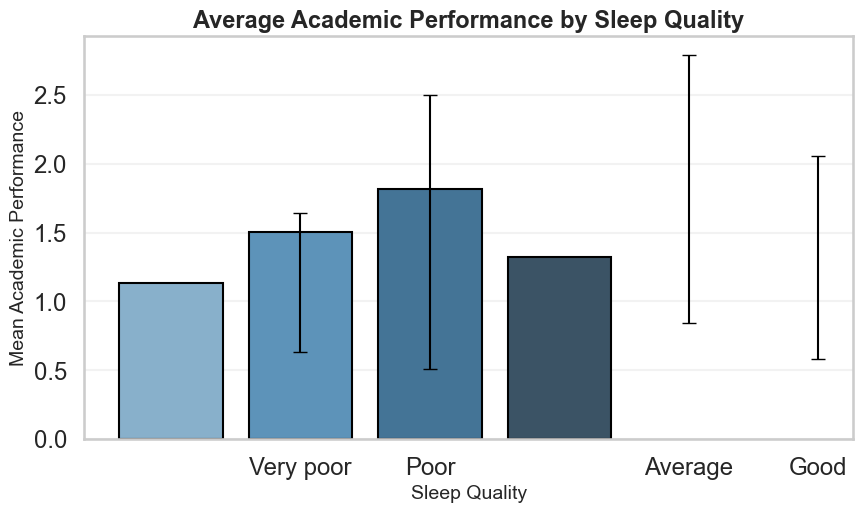

In [29]:
# Group as before
grp = (
    df[["sleep_quality_ord", "acad_perf_ord"]]
    .dropna()
    .groupby("sleep_quality_ord")
    .acad_perf_ord.agg(["mean", "std", "count"])
    .reset_index()
)

# Use only the levels that exist in your data
present_levels = sorted(grp["sleep_quality_ord"].unique())
present_labels = [sleep_quality_labels[k] for k in present_levels]

plt.figure(figsize=(9,5.5))
ax = sns.barplot(x="sleep_quality_ord", y="mean", data=grp,
                 palette="Blues_d", ci=None, edgecolor="black")

plt.errorbar(grp["sleep_quality_ord"], grp["mean"], yerr=grp["std"],
             fmt="none", ecolor="black", capsize=5, linewidth=1.5)

ax.set_xticks(present_levels)
ax.set_xticklabels(present_labels, rotation=0)
plt.xlabel("Sleep Quality")
plt.ylabel("Mean Academic Performance")
plt.title("Average Academic Performance by Sleep Quality", fontsize=17, weight="bold")
plt.tight_layout()
plt.savefig(FIG/"bar_acad_by_sleep_quality_clean.png", dpi=300)
plt.show()


In [31]:
import pandas as pd

# ======= LOAD CSV =======
file_path = "/Users/muthuraj/Desktop/git hub/Mind-Metrics/Student Insomnia and Educational Outcomes Dataset_version-2.csv"  # change this to your actual file path
df = pd.read_csv(file_path)

print("\n✅ STEP 1: Basic Info")
print("="*60)
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nFirst 5 rows:")
print(df.head(5))

# ======= NULLS & DUPLICATES =======
print("\n✅ STEP 2: Missing / Null Data")
print("="*60)
print(df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())

# ======= UNIQUE VALUE COUNTS =======
print("\n✅ STEP 3: Unique Values per Column")
print("="*60)
for col in df.columns:
    print(f"\n--- {col} ---")
    print(df[col].value_counts(dropna=False).head(10))

# ======= SUMMARY STATISTICS =======
print("\n✅ STEP 4: Summary (Numeric columns)")
print("="*60)
print(df.describe())

# ======= STRING NORMALIZATION CHECK =======
print("\n✅ STEP 5: Sample Text Values")
print("="*60)
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"\nColumn: {col}")
        print(df[col].sample(5, random_state=42).tolist())

# ======= CHECK COLUMN NAMES CLEANLINESS =======
print("\n✅ STEP 6: Column name cleanup suggestion")
print("="*60)
clean_cols = [c.strip().replace(" ", "_").replace("?", "").replace(".", "").replace("/", "_").lower() for c in df.columns]
print(clean_cols)

print("\n✅ STEP 7: Shape and Memory Info")
print("="*60)
print(df.info(memory_usage='deep'))



✅ STEP 1: Basic Info
Shape: (996, 16)

Columns:
 ['Timestamp', '1. What is your year of study?', '2. What is your gender?', '3. How often do you have difficulty falling asleep at night? ', '4. On average, how many hours of sleep do you get on a typical day?', '5. How often do you wake up during the night and have trouble falling back asleep?', '6. How would you rate the overall quality of your sleep?', '7. How often do you experience difficulty concentrating during lectures or studying due to lack of sleep?', '8. How often do you feel fatigued during the day, affecting your ability to study or attend classes?', '9. How often do you miss or skip classes due to sleep-related issues (e.g., insomnia, feeling tired)?', '10. How would you describe the impact of insufficient sleep on your ability to complete assignments and meet deadlines?', '11. How often do you use electronic devices (e.g., phone, computer) before going to sleep?', '12. How often do you consume caffeine (coffee, energy dri

✅ Loaded: (996, 16)

🔍 Missing values (top 10):
Timestamp                         0.0
1. What is your year of study?    0.0
stress_ord                        0.0
sleep_quality_ord                 0.0
sleep_hours                       0.0
academic_performance              0.0
stress                            0.0
physical_activity                 0.0
caffeine                          0.0
devices_before_sleep              0.0
dtype: float64

🔍 Sample encoded data:
   sleep_hours  sleep_quality_ord  stress_ord  acad_perf_ord
0          7.5                  4           3              3
1          7.5                  4           2              4
2          7.5                  4           3              2
3          8.5                  2           4              5
4          7.5                  5           2              3
5          7.5                  5           3              2
6          7.5                  4           1              4
7          8.5                  4           2

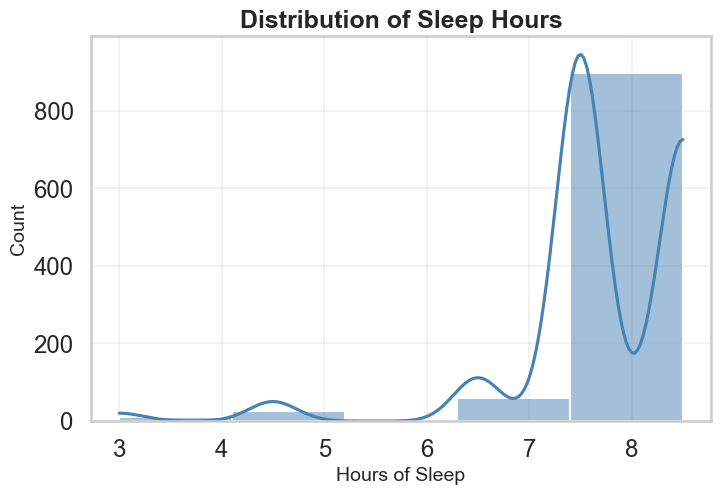

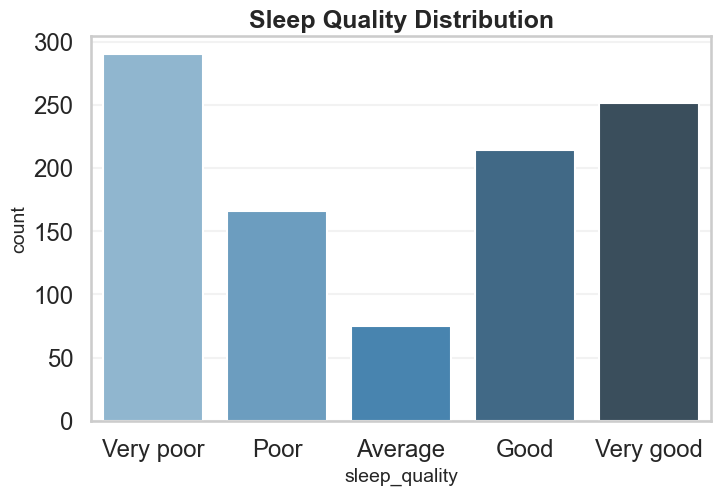

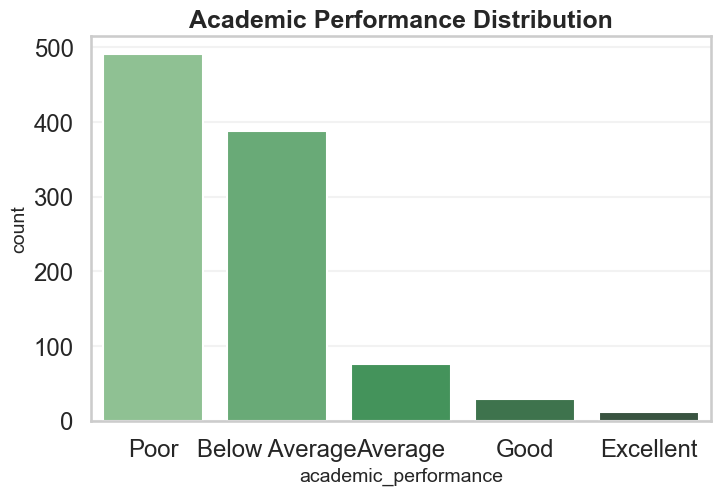

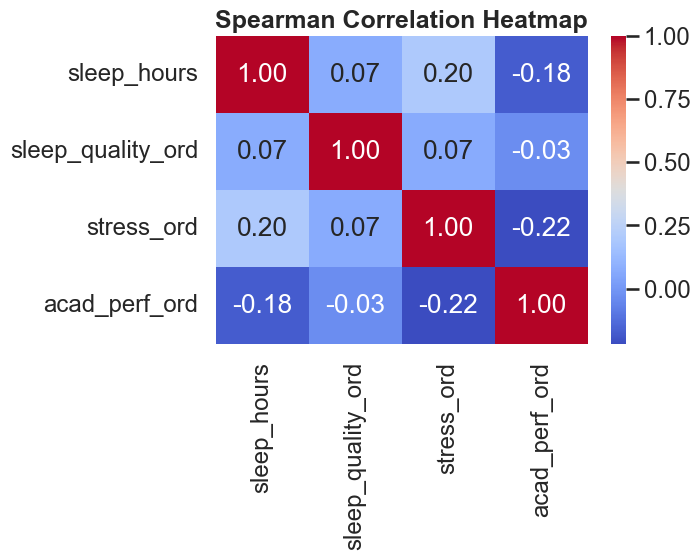


🎯 Hypothesis Tests
H1: Sleep hours vs Academic performance → Spearman rho=-0.176, p=2.384e-08
H2: Sleep quality vs Academic performance → H=65.830, p=1.721e-13
H3: Stress vs Concentration difficulty → Spearman rho=0.288, p=1.723e-20


In [32]:
# =========================================
# STEP 1 — IMPORTS & LOAD DATA
# =========================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kruskal

path = "/Users/muthuraj/Desktop/git hub/Mind-Metrics/Student Insomnia and Educational Outcomes Dataset_version-2.csv"
df = pd.read_csv(path)
print("✅ Loaded:", df.shape)

# =========================================
# STEP 2 — RENAME COLUMNS (short & clean)
# =========================================
rename_map = {
    df.columns[3]: "sleep_difficulty",
    df.columns[4]: "sleep_hours_band",
    df.columns[5]: "night_awakenings",
    df.columns[6]: "sleep_quality",
    df.columns[7]: "concentration_difficulty",
    df.columns[8]: "daytime_fatigue",
    df.columns[9]: "miss_classes",
    df.columns[10]: "assignments_impact",
    df.columns[11]: "devices_before_sleep",
    df.columns[12]: "caffeine",
    df.columns[13]: "physical_activity",
    df.columns[14]: "stress",
    df.columns[15]: "academic_performance",
}
df = df.rename(columns=rename_map)

# =========================================
# STEP 3 — CONVERT SLEEP HOURS TO NUMERIC
# =========================================
hours_map = {
    "Less than 4 hours": 3,
    "4-5 hours": 4.5,
    "6-7 hours": 6.5,
    "7-8 hours": 7.5,
    "More than 8 hours": 8.5
}
df["sleep_hours"] = df["sleep_hours_band"].map(hours_map)

# =========================================
# STEP 4 — ENCODE ORDINAL CATEGORIES
# =========================================
sleep_quality_map = {
    "Very poor": 1, "Poor": 2, "Average": 3, "Good": 4, "Very good": 5
}
stress_map = {
    "No stress": 1, "Low stress": 2, "High stress": 3, "Extremely high stress": 4
}
acad_perf_map = {
    "Poor": 1, "Below Average": 2, "Average": 3, "Good": 4, "Excellent": 5
}

df["sleep_quality_ord"] = df["sleep_quality"].map(sleep_quality_map)
df["stress_ord"] = df["stress"].map(stress_map)
df["acad_perf_ord"] = df["academic_performance"].map(acad_perf_map)

# =========================================
# STEP 5 — QUICK DATA CHECK
# =========================================
print("\n🔍 Missing values (top 10):")
print(df.isnull().mean().sort_values(ascending=False).head(10))

print("\n🔍 Sample encoded data:")
print(df[["sleep_hours", "sleep_quality_ord", "stress_ord", "acad_perf_ord"]].head(10))

# =========================================
# STEP 6 — VISUAL EXPLORATORY ANALYSIS
# =========================================
plt.figure(figsize=(8,5))
sns.histplot(df["sleep_hours"], bins=5, kde=True, color="steelblue")
plt.title("Distribution of Sleep Hours")
plt.xlabel("Hours of Sleep")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x="sleep_quality", data=df, order=["Very poor","Poor","Average","Good","Very good"], palette="Blues_d")
plt.title("Sleep Quality Distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x="academic_performance", data=df, order=["Poor","Below Average","Average","Good","Excellent"], palette="Greens_d")
plt.title("Academic Performance Distribution")
plt.show()

# =========================================
# STEP 7 — CORRELATION HEATMAP
# =========================================
num_cols = ["sleep_hours", "sleep_quality_ord", "stress_ord", "acad_perf_ord"]
plt.figure(figsize=(6,4))
sns.heatmap(df[num_cols].corr(method="spearman"), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman Correlation Heatmap")
plt.show()

# =========================================
# STEP 8 — HYPOTHESIS TESTS
# =========================================
print("\n🎯 Hypothesis Tests\n" + "="*40)

# H1: Sleep hours vs Academic performance
rho, p = spearmanr(df["sleep_hours"], df["acad_perf_ord"], nan_policy='omit')
print(f"H1: Sleep hours vs Academic performance → Spearman rho={rho:.3f}, p={p:.3e}")

# H2: Sleep quality vs Academic performance
groups = [g["acad_perf_ord"].dropna() for _, g in df.groupby("sleep_quality_ord")]
H, p = kruskal(*groups)
print(f"H2: Sleep quality vs Academic performance → H={H:.3f}, p={p:.3e}")

# H3: Stress vs Concentration difficulty (approx using encoded)
stress_ord = df["stress_ord"]
conc_map = {"Never":1,"Rarely":2,"Sometimes":3,"Often":4,"Always":5}
df["concentration_difficulty_ord"] = df["concentration_difficulty"].map(conc_map)
rho, p = spearmanr(stress_ord, df["concentration_difficulty_ord"], nan_policy='omit')
print(f"H3: Stress vs Concentration difficulty → Spearman rho={rho:.3f}, p={p:.3e}")



✅ STEP 8: Mapping Verification
   sleep_hours sleep_quality  sleep_quality_ord                 stress  \
0          7.5          Good                  4            High stress   
1          7.5          Good                  4             Low stress   
2          7.5          Good                  4            High stress   
3          8.5          Poor                  2  Extremely high stress   
4          7.5     Very good                  5             Low stress   
5          7.5     Very good                  5            High stress   
6          7.5          Good                  4              No stress   
7          8.5          Good                  4             Low stress   
8          8.5       Average                  3  Extremely high stress   
9          8.5     Very good                  5            High stress   

   stress_ord academic_performance  acad_perf_ord  
0           3              Average              3  
1           2                 Good              4

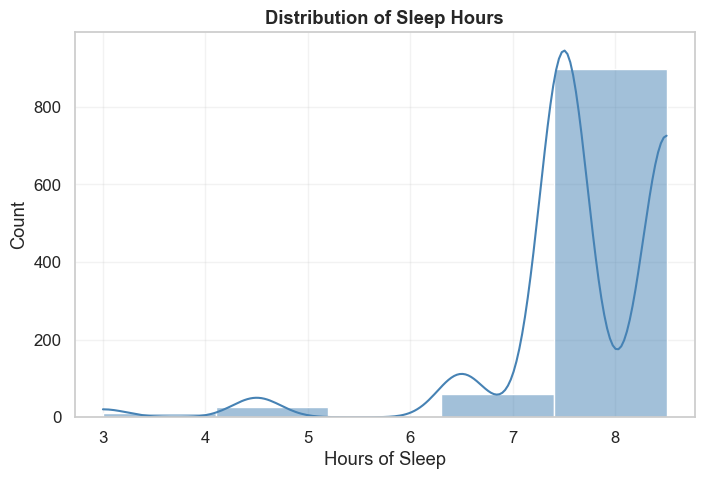

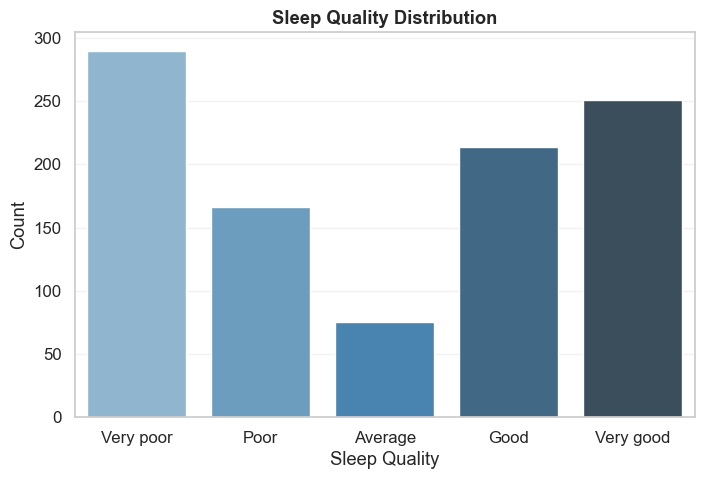

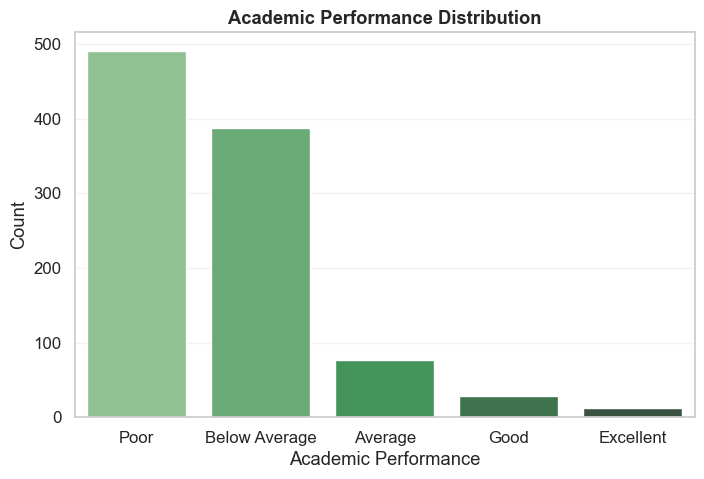

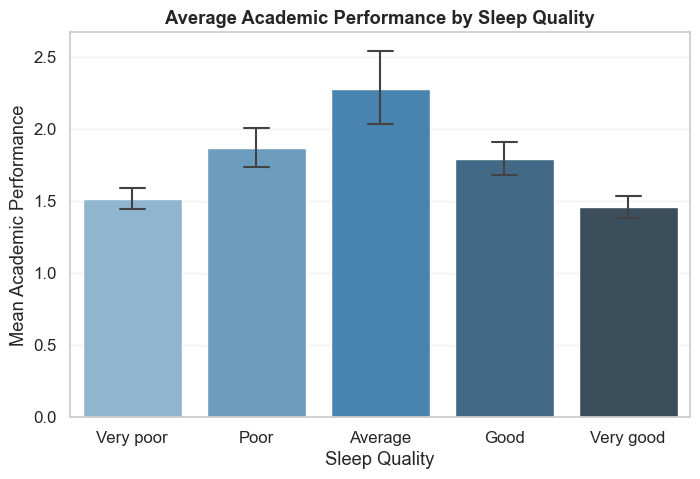

In [39]:
# ================================================================
# ✅ STEP 8: PREPROCESSING & CLEAN MAPPING
# ================================================================
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kruskal

# --- Rename columns for simplicity ---
rename_map = {
    df.columns[3]: "sleep_difficulty",
    df.columns[4]: "sleep_hours_band",
    df.columns[5]: "night_awakenings",
    df.columns[6]: "sleep_quality",
    df.columns[7]: "concentration_difficulty",
    df.columns[8]: "daytime_fatigue",
    df.columns[9]: "miss_classes",
    df.columns[10]: "assignments_impact",
    df.columns[11]: "devices_before_sleep",
    df.columns[12]: "caffeine",
    df.columns[13]: "physical_activity",
    df.columns[14]: "stress",
    df.columns[15]: "academic_performance",
}
df = df.rename(columns=rename_map)

# --- Safe Mappings (do not overwrite CSV) ---
sleep_quality_map = {
    "Very poor": 1, "Poor": 2, "Average": 3, "Good": 4, "Very good": 5
}
stress_map = {
    "No stress": 1, "Low stress": 2, "High stress": 3, "Extremely high stress": 4
}
acad_perf_map = {
    "Poor": 1, "Below Average": 2, "Average": 3, "Good": 4, "Excellent": 5
}
hours_map = {
    "Less than 4 hours": 3,
    "4-5 hours": 4.5,
    "6-7 hours": 6.5,
    "7-8 hours": 7.5,
    "More than 8 hours": 8.5
}

# --- Apply mappings ---
df["sleep_quality_ord"] = df["sleep_quality"].map(sleep_quality_map)
df["stress_ord"] = df["stress"].map(stress_map)
df["acad_perf_ord"] = df["academic_performance"].map(acad_perf_map)
df["sleep_hours"] = df["sleep_hours_band"].map(hours_map)

# --- Verify mapping results ---
print("\n✅ STEP 8: Mapping Verification")
print("="*60)
print(df[["sleep_hours", "sleep_quality", "sleep_quality_ord", "stress", "stress_ord", 
          "academic_performance", "acad_perf_ord"]].head(10))

print("\nUnique Encoded Values:")
for col in ["sleep_quality_ord", "stress_ord", "acad_perf_ord"]:
    print(f"{col}: {sorted(df[col].dropna().unique())}")

# ================================================================
# ✅ STEP 9: EXPLORATORY DATA ANALYSIS (EDA)
# ================================================================
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# --- Distribution of Sleep Hours ---
plt.figure(figsize=(8,5))
sns.histplot(df["sleep_hours"], bins=5, kde=True, color="steelblue")
plt.title("Distribution of Sleep Hours")
plt.xlabel("Hours of Sleep")
plt.ylabel("Count")
plt.show()

# --- Sleep Quality Distribution ---
plt.figure(figsize=(8,5))
sns.countplot(
    x="sleep_quality", 
    data=df, 
    order=["Very poor","Poor","Average","Good","Very good"],
    palette="Blues_d"
)
plt.title("Sleep Quality Distribution")
plt.xlabel("Sleep Quality")
plt.ylabel("Count")
plt.show()

# --- Academic Performance Distribution ---
plt.figure(figsize=(8,5))
sns.countplot(
    x="academic_performance", 
    data=df,
    order=["Poor","Below Average","Average","Good","Excellent"],
    palette="Greens_d"
)
plt.title("Academic Performance Distribution")
plt.xlabel("Academic Performance")
plt.ylabel("Count")
plt.show()




# --- Average Academic Performance by Sleep Quality ---
plt.figure(figsize=(8,5))
sns.barplot(
    x="sleep_quality", 
    y="acad_perf_ord", 
    data=df,
    order=["Very poor","Poor","Average","Good","Very good"],
    palette="Blues_d",
    capsize=0.2,
    errwidth=1.5
)
plt.title("Average Academic Performance by Sleep Quality")
plt.xlabel("Sleep Quality")
plt.ylabel("Mean Academic Performance")
plt.show()

# ================================================================
# ✅ STEP 11: SAVE CLEAN VERSION (OPTIONAL)
# ================================================================
# Uncomment if you want to save clean version (safe copy)
# df.to_csv("/Users/muthuraj/Desktop/git hub/Mind-Metrics/cleaned_sleep_study.csv", index=False)


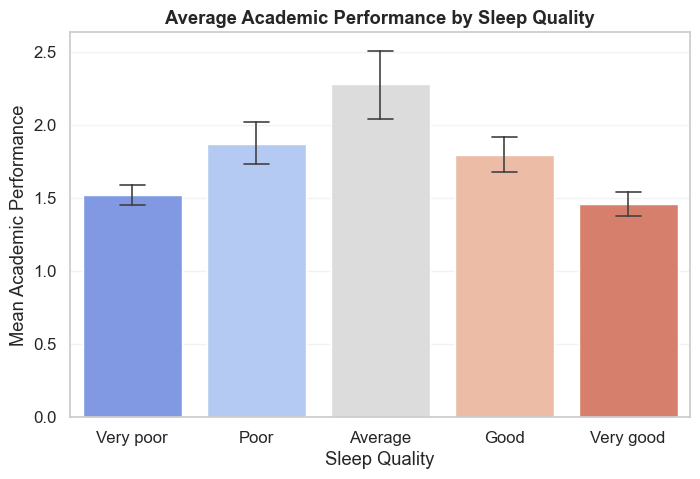

In [35]:
plt.figure(figsize=(8,5))
sns.barplot(
    x="sleep_quality",
    y="acad_perf_ord",
    data=df,
    order=["Very poor","Poor","Average","Good","Very good"],
    palette="coolwarm",
    capsize=0.2,
    errwidth=1.2
)
plt.title("Average Academic Performance by Sleep Quality")
plt.xlabel("Sleep Quality")
plt.ylabel("Mean Academic Performance")
plt.show()


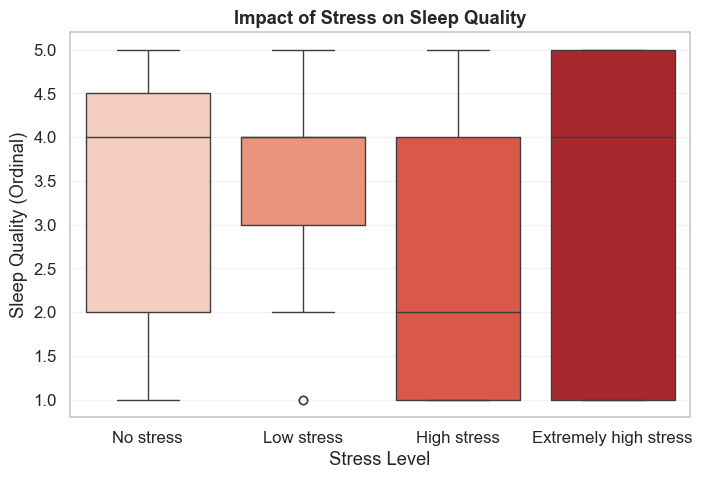

In [36]:
plt.figure(figsize=(8,5))
sns.boxplot(
    x="stress",
    y="sleep_quality_ord",
    data=df,
    order=["No stress","Low stress","High stress","Extremely high stress"],
    palette="Reds"
)
plt.title("Impact of Stress on Sleep Quality")
plt.xlabel("Stress Level")
plt.ylabel("Sleep Quality (Ordinal)")
plt.show()


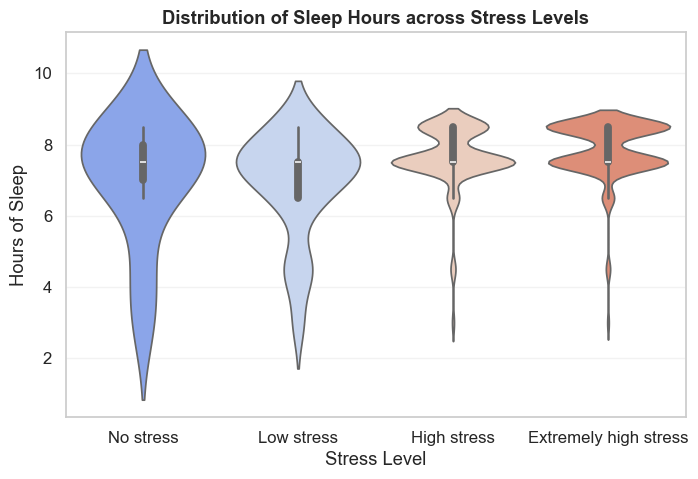

In [37]:
plt.figure(figsize=(8,5))
sns.violinplot(
    x="stress",
    y="sleep_hours",
    data=df,
    order=["No stress","Low stress","High stress","Extremely high stress"],
    palette="coolwarm"
)
plt.title("Distribution of Sleep Hours across Stress Levels")
plt.xlabel("Stress Level")
plt.ylabel("Hours of Sleep")
plt.show()


In [40]:

# PREPROCESSING PIPELINE

import pandas as pd
import numpy as np
from pathlib import Path


file_path = "/Users/muthuraj/Desktop/git hub/Mind-Metrics/Student Insomnia and Educational Outcomes Dataset_version-2.csv"
save_clean_csv = True
out_dir = Path("/Users/muthuraj/Desktop/git hub/Mind-Metrics/insomnia_out")
out_dir.mkdir(parents=True, exist_ok=True)
clean_path = out_dir / "clean_dataset.csv"

# --- LOAD ---
df_raw = pd.read_csv(file_path)


df = df_raw.copy()
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()

# --- Column aliases ) ---
col_year   = "1. What is your year of study?"
col_gender = "2. What is your gender?"
col_diff   = "3. How often do you have difficulty falling asleep at night? "
col_hours  = "4. On average, how many hours of sleep do you get on a typical day?"
col_awake  = "5. How often do you wake up during the night and have trouble falling back asleep?"
col_squal  = "6. How would you rate the overall quality of your sleep?"
col_conc   = "7. How often do you experience difficulty concentrating during lectures or studying due to lack of sleep?"
col_fatigue= "8. How often do you feel fatigued during the day, affecting your ability to study or attend classes?"
col_miss   = "9. How often do you miss or skip classes due to sleep-related issues (e.g., insomnia, feeling tired)?"
col_impact = "10. How would you describe the impact of insufficient sleep on your ability to complete assignments and meet deadlines?"
col_device = "11. How often do you use electronic devices (e.g., phone, computer) before going to sleep?"
col_caff   = "12. How often do you consume caffeine (coffee, energy drinks) to stay awake or alert?"
col_pa     = "13. How often do you engage in physical activity or exercise?"
col_stress = "14. How would you describe your stress levels related to academic workload?"
col_acad   = "15. How would you rate your overall academic performance (GPA or grades) in the past semester?"

# --- Canonical category mappings ---
# Sleep quality (ordinal: Very poor → Very good)
sleep_quality_order = ["Very poor", "Poor", "Average", "Good", "Very good"]
sleep_quality_to_ord = {k:i+1 for i,k in enumerate(sleep_quality_order)} 

# Stress (ordinal)
stress_order = ["No stress", "Low stress", "High stress", "Extremely high stress"]
stress_to_ord = {k:i+1 for i,k in enumerate(stress_order)}  

# Academic performance (ordinal)
acad_order = ["Poor", "Below Average", "Average", "Good", "Excellent"]
acad_to_ord = {k:i+1 for i,k in enumerate(acad_order)}       

# Sleep hours band → midpoint (float)
def hours_band_to_midpoint(x: str) -> float:
    x = x.strip()
    if x == "Less than 4 hours":  return 3.5
    if x == "4-5 hours":          return 4.5
    if x == "6-7 hours":          return 6.5
    if x == "7-8 hours":          return 7.5
    if x == "More than 8 hours":  return 8.5
    return np.nan  


t = pd.DataFrame({
    "timestamp": df["Timestamp"],
    "year": df[col_year],
    "gender": df[col_gender],
    "sleep_hours_band": df[col_hours],
    "sleep_quality": df[col_squal],
    "stress": df[col_stress],
    "academic_performance": df[col_acad]
})

# numeric encodings 
t["sleep_hours"] = t["sleep_hours_band"].map(hours_band_to_midpoint)
t["sleep_quality_ord"] = t["sleep_quality"].map(sleep_quality_to_ord)
t["stress_ord"] = t["stress"].map(stress_to_ord)
t["acad_perf_ord"] = t["academic_performance"].map(acad_to_ord)

# --- Checks ---
print("Loaded:", df.shape)
print("\n Missing values (top 10):")
print(t[["sleep_hours","sleep_quality","sleep_quality_ord","stress","stress_ord","academic_performance","acad_perf_ord"]]
      .isnull().mean().sort_values(ascending=False).head(10))

print("\n Sample encoded data:")
print(t[["sleep_hours","sleep_quality_ord","stress_ord","acad_perf_ord"]].head(10))

# --- Save clean CSV for downstream use (optional) ---
if save_clean_csv:
    t.to_csv(clean_path, index=False)
    print(f"\n Clean dataset saved → {clean_path}")


Loaded: (996, 16)

 Missing values (top 10):
sleep_hours             0.0
sleep_quality           0.0
sleep_quality_ord       0.0
stress                  0.0
stress_ord              0.0
academic_performance    0.0
acad_perf_ord           0.0
dtype: float64

 Sample encoded data:
   sleep_hours  sleep_quality_ord  stress_ord  acad_perf_ord
0          7.5                  4           3              3
1          7.5                  4           2              4
2          7.5                  4           3              2
3          8.5                  2           4              5
4          7.5                  5           2              3
5          7.5                  5           3              2
6          7.5                  4           1              4
7          8.5                  4           2              4
8          8.5                  3           4              3
9          8.5                  5           3              1

 Clean dataset saved → /Users/muthuraj/Desktop/gi

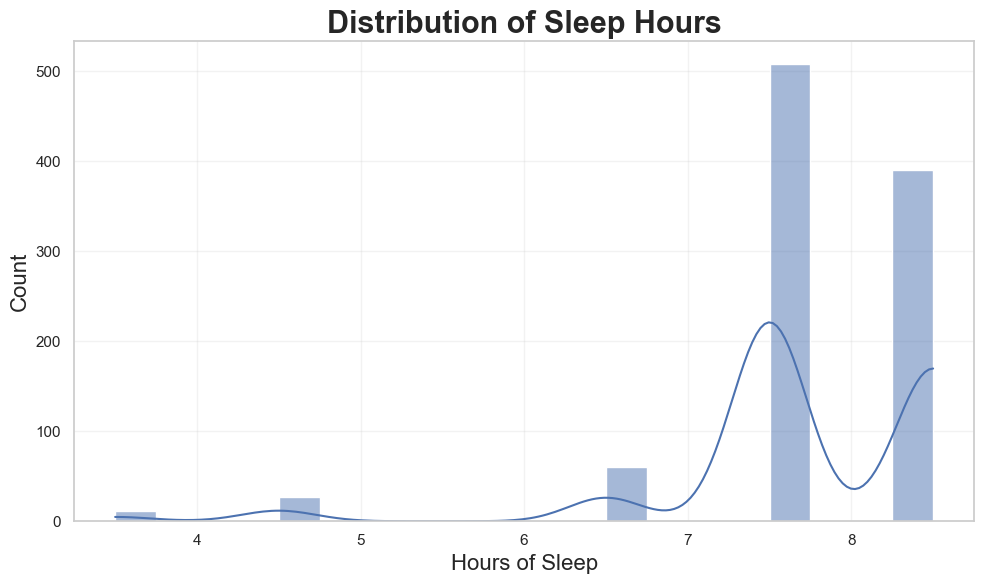

In [41]:
# =========================
# EDA: Distribution of Sleep Hours
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the clean set (or reuse 't' if in same session)
clean_path = "/Users/muthuraj/Desktop/git hub/Mind-Metrics/insomnia_out/clean_dataset.csv"
t = pd.read_csv(clean_path)

sns.set(style="whitegrid", rc={"axes.titlesize":22, "axes.labelsize":16})
plt.figure(figsize=(10,6))
sns.histplot(t["sleep_hours"], bins=20, kde=True)
plt.title("Distribution of Sleep Hours")
plt.xlabel("Hours of Sleep")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


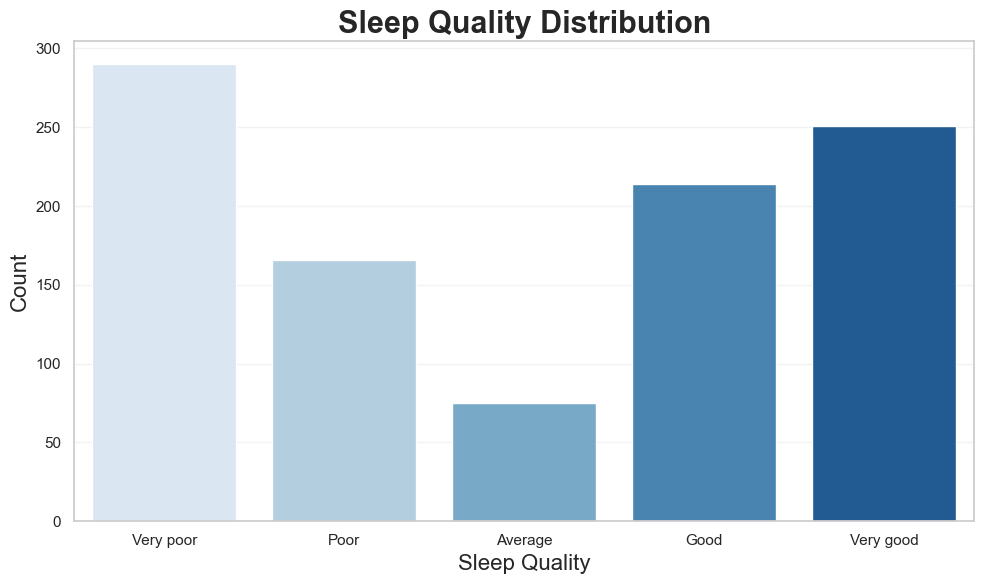

In [42]:
# =========================
# EDA: Sleep Quality Distribution
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

clean_path = "/Users/muthuraj/Desktop/git hub/Mind-Metrics/insomnia_out/clean_dataset.csv"
t = pd.read_csv(clean_path)

order = ["Very poor", "Poor", "Average", "Good", "Very good"]
sns.set(style="whitegrid", rc={"axes.titlesize":22, "axes.labelsize":16})
plt.figure(figsize=(10,6))
sns.countplot(data=t, x="sleep_quality", order=order, palette="Blues")
plt.title("Sleep Quality Distribution")
plt.xlabel("Sleep Quality")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


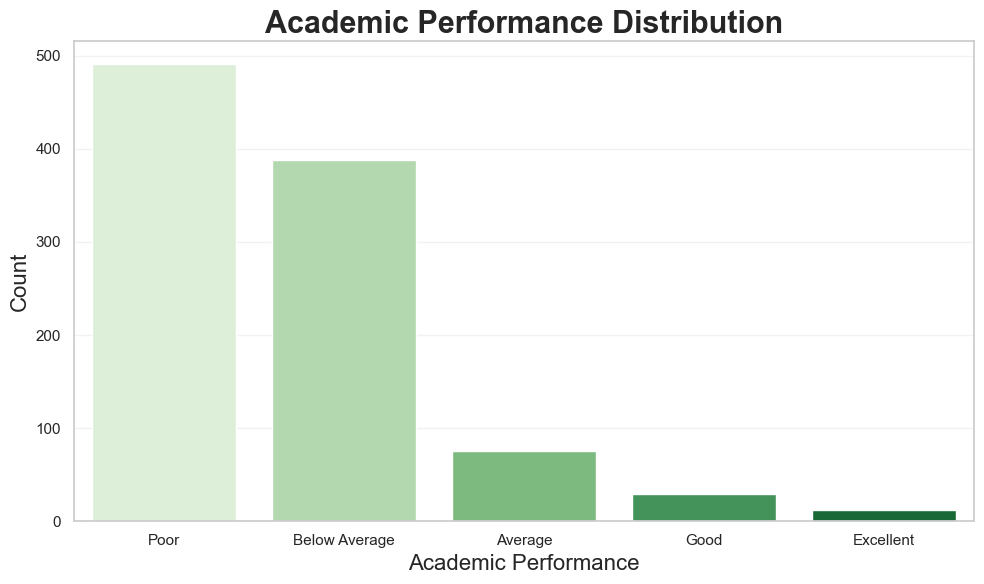

In [43]:
# =========================
# EDA: Academic Performance Distribution
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

clean_path = "/Users/muthuraj/Desktop/git hub/Mind-Metrics/insomnia_out/clean_dataset.csv"
t = pd.read_csv(clean_path)

acad_order = ["Poor", "Below Average", "Average", "Good", "Excellent"]
sns.set(style="whitegrid", rc={"axes.titlesize":22, "axes.labelsize":16})
plt.figure(figsize=(10,6))
sns.countplot(data=t, x="academic_performance", order=acad_order, palette="Greens")
plt.title("Academic Performance Distribution")
plt.xlabel("Academic Performance")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


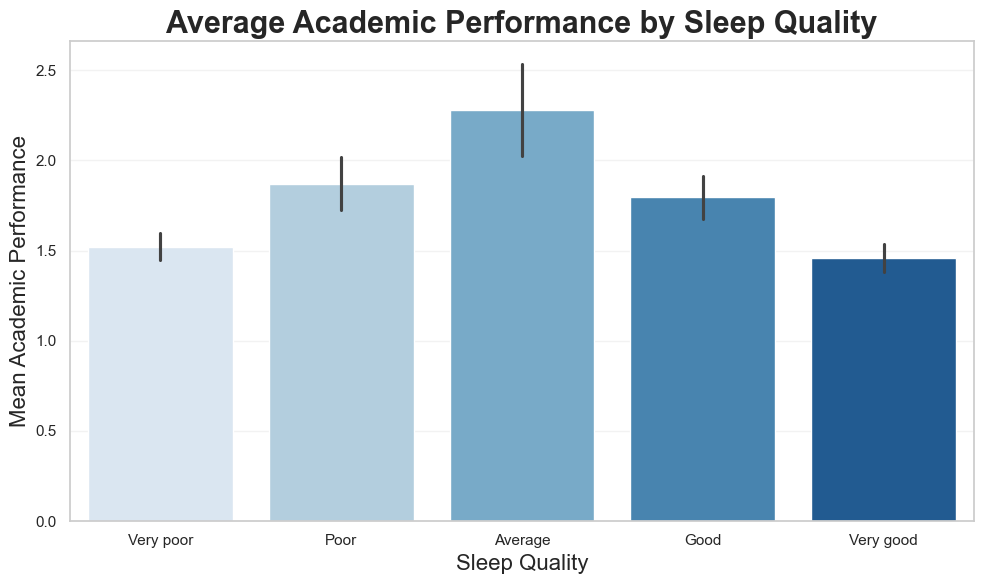

In [44]:
# =========================
# EDA: Mean Academic Performance by Sleep Quality
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

clean_path = "/Users/muthuraj/Desktop/git hub/Mind-Metrics/insomnia_out/clean_dataset.csv"
t = pd.read_csv(clean_path)

order = ["Very poor", "Poor", "Average", "Good", "Very good"]
sns.set(style="whitegrid", rc={"axes.titlesize":22, "axes.labelsize":16})
plt.figure(figsize=(10,6))
sns.barplot(
    data=t, x="sleep_quality", y="acad_perf_ord",
    order=order, palette="Blues", ci=95, estimator=np.mean
)
plt.title("Average Academic Performance by Sleep Quality")
plt.xlabel("Sleep Quality")
plt.ylabel("Mean Academic Performance")
plt.tight_layout()
plt.show()


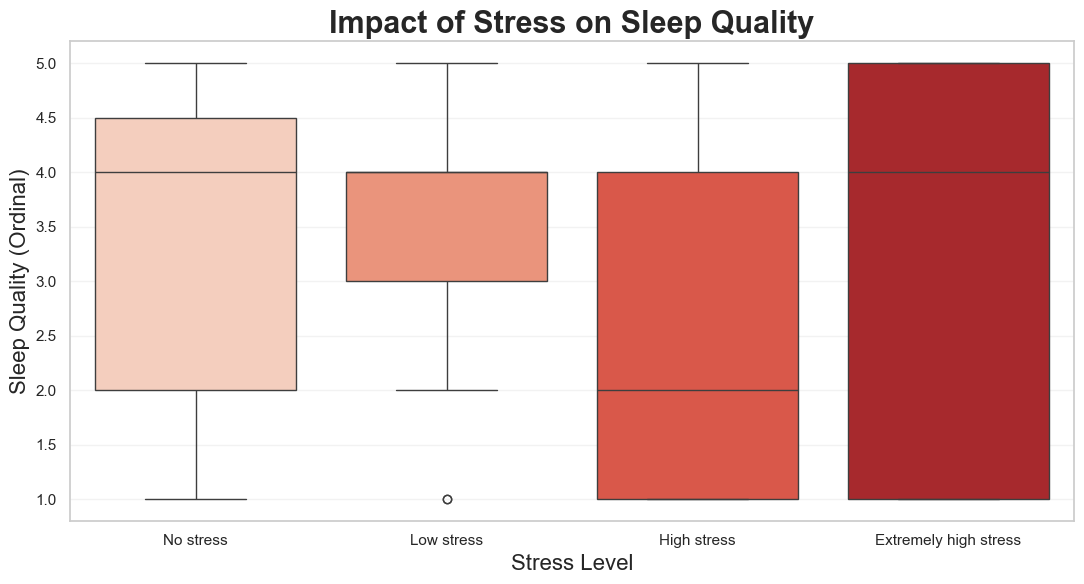

In [45]:
# =========================
# EDA: Impact of Stress on Sleep Quality (Boxplot)
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

clean_path = "/Users/muthuraj/Desktop/git hub/Mind-Metrics/insomnia_out/clean_dataset.csv"
t = pd.read_csv(clean_path)

stress_order = ["No stress", "Low stress", "High stress", "Extremely high stress"]
sns.set(style="whitegrid", rc={"axes.titlesize":22, "axes.labelsize":16})
plt.figure(figsize=(11,6))
sns.boxplot(
    data=t, x="stress", y="sleep_quality_ord",
    order=stress_order, palette="Reds"
)
plt.title("Impact of Stress on Sleep Quality")
plt.xlabel("Stress Level")
plt.ylabel("Sleep Quality (Ordinal)")
plt.tight_layout()
plt.show()


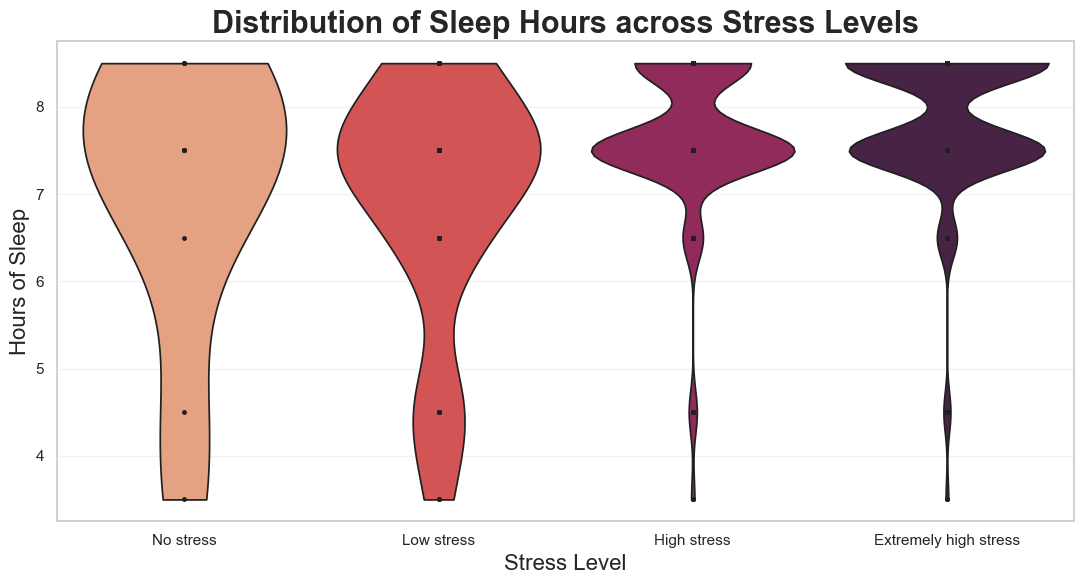

In [46]:
# =========================
# EDA: Distribution of Sleep Hours across Stress Levels (Violin)
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

clean_path = "/Users/muthuraj/Desktop/git hub/Mind-Metrics/insomnia_out/clean_dataset.csv"
t = pd.read_csv(clean_path)

stress_order = ["No stress", "Low stress", "High stress", "Extremely high stress"]
sns.set(style="whitegrid", rc={"axes.titlesize":22, "axes.labelsize":16})
plt.figure(figsize=(11,6))
sns.violinplot(
    data=t, x="stress", y="sleep_hours",
    order=stress_order, inner="point", cut=0, palette="rocket_r"
)
plt.title("Distribution of Sleep Hours across Stress Levels")
plt.xlabel("Stress Level")
plt.ylabel("Hours of Sleep")
plt.tight_layout()
plt.show()
